# Good Read Reviews Sentiment Analysis Using ANN , RNN

In [35]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
 good_reads = pd.read_csv('goodreads.tsv' , sep='\t') #names=['user_id','song_id','play_count'])

In [3]:
good_reads.head()

,title,date,rating,body
0,The Body: A Guide for Occupants,"Oct 11, 2019",5.0,Lovingly presented with humour and kindness an...
1,Resistance Reborn,"Feb 28, 2020",4.0,I read through this book quicker than anticip...
2,The Book of Two Ways,"Jul 13, 2020",4.0,Jodi Picoult does it again in this new novel. ...
3,How to Write One Song: Loving the Things We Cr...,"Feb 21, 2021",4.0,I’m a music freak without a shred of musical a...
4,The Giver of Stars,"Sep 08, 2020",4.0,The Giver of Stars by Jojo Moyes won the Book ...


In [4]:
good_reads.shape

(8433, 4)

In [5]:
#Checking For Null Values
good_reads.isnull().sum()

title       0
date        4
rating    290
body        4
dtype: int64

In [6]:
#Dropping Null Values
good_reads=good_reads.dropna()

In [7]:
good_reads.shape

(8139, 4)

In [8]:
#Chaning review data of every row into string type
for i in range(0,len(good_reads)-1):
    if type(good_reads.iloc[i]['body']) != str:
        good_reads.iloc[i]['body'] = str(good_reads.iloc[i]['body'])

In [9]:
#3 is in the middle. It’s neither good nor bad. Just average. 
#But we want to classify good or bad reviews. So, I decided to get rid of all the 3’s

good_reads = good_reads[good_reads['rating'] != 3]

In [10]:
good_reads.shape

(6709, 4)

In [11]:
#function to represent sentiment 0(negeative);1(positive)
def sentiment(n):
    return 1 if n>=4 else 0

In [12]:
#Applying Sentiment Function to our Data Frame
good_reads['sentiment'] = good_reads['rating'].apply(sentiment)

In [13]:
good_reads.tail()

,title,date,rating,body,sentiment
8428,The Giver of Stars,"Feb 12, 2020",5.0,I loved this book! Let me start by saying that...,1
8429,Minor Feelings: An Asian American Reckoning,"May 21, 2020",4.0,What did i just read?I chose this title becaus...,1
8430,Trixie and Katya's Guide to Modern Womanhood,"Oct 29, 2020",4.0,**3.45 stars ( if we were using a 10/10 scale ...,1
8431,To Wake the Giant: A Novel of Pearl Harbor,"May 22, 2020",4.0,"Thanks to Netgalley, Random House and Ballenti...",1
8432,Finding Ashley,"Apr 14, 2021",4.0,Finding Ashley starts with Melissa working har...,1


## Data Cleaning

In [14]:
# Applyling some pre-processing on the given text.
def clean_text(text):
    """
    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [16]:
X = []
sentences = list(good_reads['body'])
for sen in sentences:
    X.append(clean_text(sen))

In [17]:
X[2]

'jodi picoult does it again in this new novel  as a plane is about to crash the main character doesnt think of family  her husband or her life flashing before her eyes  she thinks of wyatt  a man she hasnt seen in 15 years  this book kept me flipping the pages and literally took me on a trip '

In [18]:
y = good_reads['sentiment']

In [19]:
#Spilting Test and Train data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

### Word To Index

In [21]:
#Preparing the Embedding Layer - To Create Word To Index Dictionary

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


### Padding

In [22]:
#finding the vocabulary size and then perform padding 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
X_train

array([[  16,   15,  126, ...,   11,  308,  206],
       [ 146,   37,  957, ...,    1,    5,   11],
       [   2,  278,    5, ...,   72,  269,   35],
       ...,
       [   9,   12,  717, ...,    0,    0,    0],
       [  10,    4, 1088, ..., 2260,  133, 1567],
       [   9,   12,   21, ...,    0,    0,    0]])

### GloVe embeddings to create our feature matrix

In [24]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [25]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.42923999,  0.29879001,  0.93342   , ..., -0.75581998,
         0.039438  ,  1.14909995],
       [ 0.35578001,  1.09560001, -0.34011999, ...,  0.043319  ,
         0.1331    ,  0.029326  ],
       [-0.35716   , -0.30851001,  0.1172    , ..., -0.62711   ,
         0.15362   ,  0.51257998]])

## Text Classification with Simple Neural Network

In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2895800   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 2,905,801
Trainable params: 10,001
Non-trainable params: 2,895,800
_________________________________________________________________
None


In [30]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
34/34 [==============================] - 16s 21ms/step - loss: 0.4952 - acc: 0.8351 - val_loss: 0.3927 - val_acc: 0.8613
Epoch 2/6
34/34 [==============================] - 0s 6ms/step - loss: 0.3435 - acc: 0.8685 - val_loss: 0.3783 - val_acc: 0.8650
Epoch 3/6
34/34 [==============================] - 0s 6ms/step - loss: 0.2906 - acc: 0.8774 - val_loss: 0.3776 - val_acc: 0.8641
Epoch 4/6
34/34 [==============================] - 0s 6ms/step - loss: 0.2445 - acc: 0.9025 - val_loss: 0.3804 - val_acc: 0.8622
Epoch 5/6
34/34 [==============================] - 0s 6ms/step - loss: 0.2221 - acc: 0.9115 - val_loss: 0.3880 - val_acc: 0.8631
Epoch 6/6
34/34 [==============================] - 0s 6ms/step - loss: 0.2019 - acc: 0.9215 - val_loss: 0.3827 - val_acc: 0.8594


In [31]:
score = model.evaluate(X_test, y_test, verbose=1)

42/42 [==============================] - 0s 2ms/step - loss: 0.3691 - acc: 0.8599


In [33]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.369086354970932
Test Accuracy: 0.8599106073379517


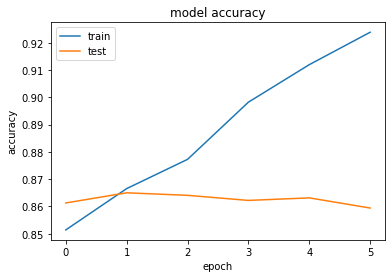

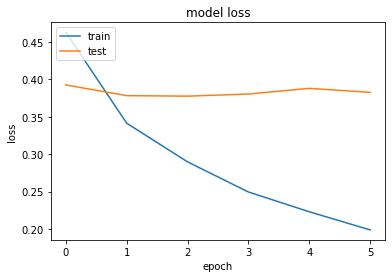

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Text Classification with Recurrent Neural Network (LSTM)

In [40]:
from keras import layers

In [41]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(layers.LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [42]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          2895800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,013,177
Trainable params: 117,377
Non-trainable params: 2,895,800
_________________________________________________________________
None


In [43]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
34/34 [==============================] - 12s 187ms/step - loss: 0.5292 - acc: 0.8000 - val_loss: 0.4073 - val_acc: 0.8594
Epoch 2/6
34/34 [==============================] - 5s 160ms/step - loss: 0.3849 - acc: 0.8698 - val_loss: 0.4023 - val_acc: 0.8594
Epoch 3/6
34/34 [==============================] - 6s 167ms/step - loss: 0.3917 - acc: 0.8644 - val_loss: 0.3992 - val_acc: 0.8594
Epoch 4/6
34/34 [==============================] - 6s 171ms/step - loss: 0.3934 - acc: 0.8625 - val_loss: 0.3925 - val_acc: 0.8594
Epoch 5/6
34/34 [==============================] - 6s 174ms/step - loss: 0.3993 - acc: 0.8559 - val_loss: 0.3858 - val_acc: 0.8594
Epoch 6/6
42/42 [==============================] - 1s 26ms/step - loss: 0.3950 - acc: 0.8621


In [44]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.39496153593063354
Test Accuracy: 0.8621460795402527


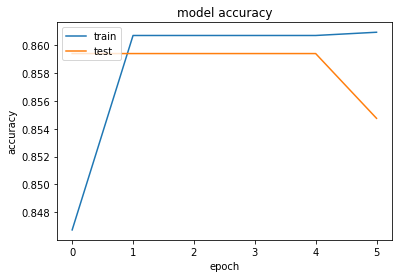

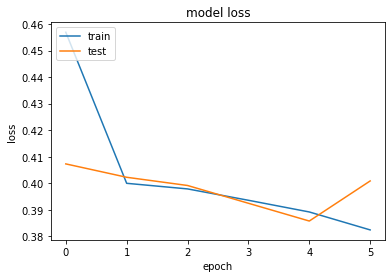

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The output shows that the difference between the accuracy values for training and test sets is much smaller compared to the simple neural network. Similarly, the different between the loss values is also negligible, which shows that our model is not overfitting. We can conclude, that for our problem, RNN is the best algorithm

In [49]:
instance = X[59]
print(instance)

this is a book that stuck with me as i was reading it  i sat in bed thinking about some of the essays  upon finishing the book wanted to immediately give it to multiple people that i know  to read  using herself and her life as a jumping off point  cathy park hong looks at america  american culture  race  and so much more with a critical and powerful eye i cant help but think about her chapter about her friends in undergraduate school in ohio that focused on female friendship  but also tied in larger themes  often at this time in america this book is anything but minor  an easy to consume  but never fully easy to read book  i will do nothing but recommend this book  im not even going to give my usual dont read this book if  read this book 


In [50]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.77368784]], dtype=float32)

<li>we mapped the positive outputs to 1 and the negative outputs to 0.</li>
<li>However, the sigmoid function predicts floating value between 0 and 1. </li>
<li>If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive.</li>

#### The sentiment value for our single instance is 0.77 which means that our sentiment is predicted as positive, which actually is the case.